## Importing the packages

In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun , TavilySearchResults

In [2]:
load_dotenv()

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [3]:
# search_tool=DuckDuckGoSearchRun()
search_tool = TavilySearchResults()


/var/folders/bt/mxzs89m9449_fkpxgpzbnhd40000gn/T/ipykernel_8670/3851193358.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults()


In [4]:
search_tool.invoke("How much tariff has Trump put on India recently?")

[{'title': 'Trump says US, India still negotiating after 25% US tariff threat',
  'url': 'https://www.reuters.com/world/india/trump-says-us-india-still-negotiating-after-25-us-tariff-threat-2025-07-30/',
  'content': "White House economic adviser Kevin Hassett said Trump has been frustrated with the progress of trade talks with India and believed the 25% tariff announcement would help the situation.\n\nThe new U.S. tax on imports from India would be higher than on many other countries that struck deals with the Trump administration recently. The tariff on Vietnamese exports is set at 20% and Indonesia's at 19%, while the levy for Japanese and European Union exports is 15%. [...] - President Donald Trump said on Wednesday the United States is still negotiating with India on trade after announcing earlier in the day the U.S. would impose a 25% tariff on goods imported from the country starting on Friday.\n\nThe 25% tariff, as well as an unspecified penalty announced by Trump in a morning

In [5]:
repl = PythonREPL()

In [6]:
code = """
a = 24
b = a // 2
print(b)
"""

In [7]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'12\n'

In [8]:
@tool
def python_repl_tool(code:str):
    """Executes the provided Python code in a REPL environment. 
    To display the result of an expression or variable, use the print() function, 
    as only printed output will be shown to the user."""

    import traceback

    try:
        result = repl.run(code)
        success = True
    except Exception as e:
        tb = traceback.format_exc()
        return (
            f"Failed to execute the provided code.\n"
            f"Error: {e}\n"
            f"Traceback:\n{tb}"
        )
    
    output = (
        f"✅ Code executed successfully:\n"
        f"```python\n{code.strip()}\n```\n"
        f"**Output:**\n{result.strip() if result else '(No output)'}"
    )
    output += "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    return output

In [9]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [10]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [11]:
research_agent = create_react_agent(
    model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [12]:
chart_agent = create_react_agent(
    model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [13]:
## creating the nodes

def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)


In [14]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [15]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

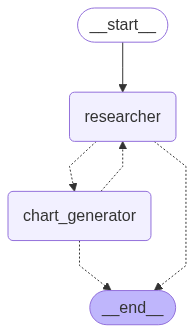

In [16]:
display(Image(app.get_graph().draw_mermaid_png()))

Matplotlib is building the font cache; this may take a moment.


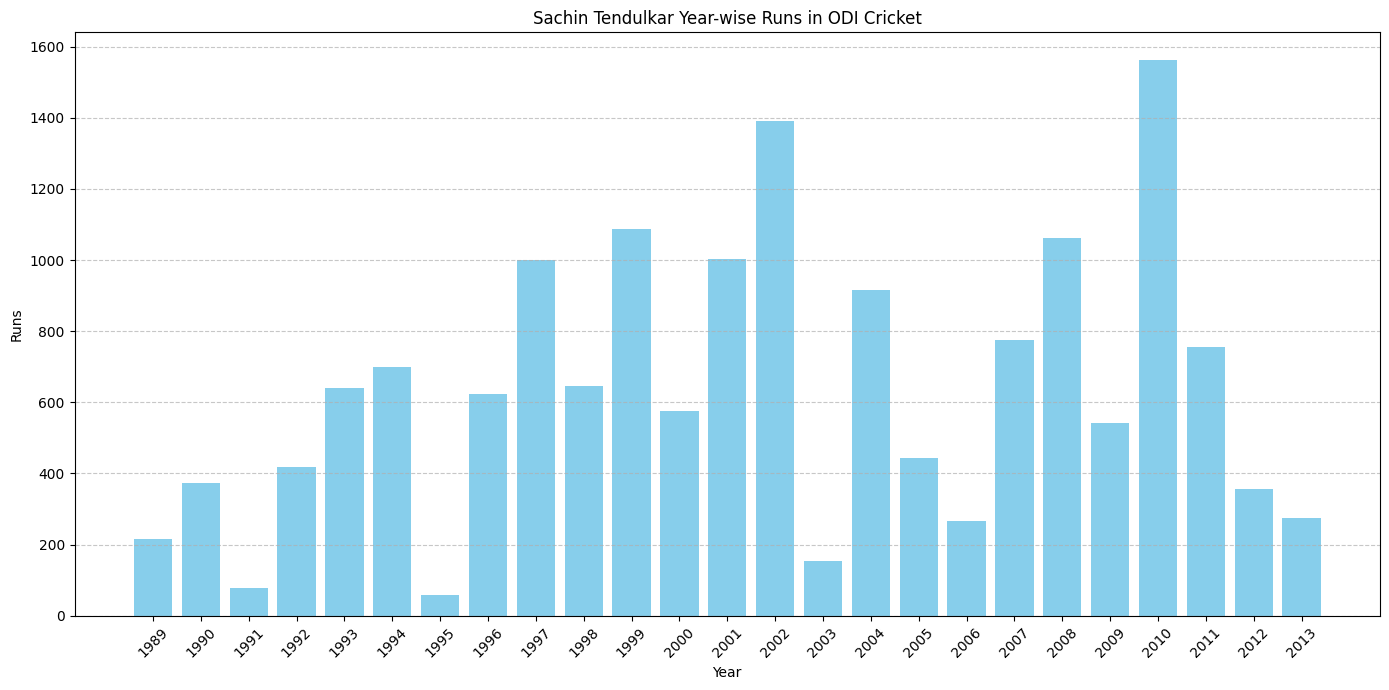

{'messages': [HumanMessage(content='Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket. \nAfter gathering the data, generate a clear and informative bar chart showing the runs performance over this period. \nOnce the chart is created, you may conclude the task.', additional_kwargs={}, response_metadata={}, id='7739ce16-959d-4074-931e-ff57b4cf1756'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GNGsDSTc3GoA4Eu6JuOm4JXs', 'function': {'arguments': '{"query":"Sachin Tendulkar year wise runs in ODI cricket"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 231, 'total_tokens': 259, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14

In [17]:
app.invoke({
    "messages": [
        (
            "user",
            "Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket. \n"
            "After gathering the data, generate a clear and informative bar chart showing the runs performance over this period. \n"
            "Once the chart is created, you may conclude the task."
        )
    ]
})

In [ ]:
app.invoke({
    "messages": [
        (
            "user",
            "Please retrieve the historical data for India NIFTY50 INDEX for past 3 years. \n"
            "After gathering the data, generate a clear and informative line chart showing the index performance over this period. \n"
            "Once the chart is created, you may conclude the task."
        )
    ]
})